In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from xgboost import XGBRegressor, plot_importance
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
plt.style.use('default')


c:\Users\abclay\Desktop\Car-Appraisal-Master\venv\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('../data/CarvanaEncoded.csv')

In [4]:
df.drop('Unnamed: 0', axis=1, inplace=True)

### After evaluating the needs for the client layer in the final app, it makes sense to drop the things from the model that people don't know about their vehicles
### For example

- Engine, and details are all fields that people typically won't know.
    - Details refers to the model specifics, that being it's a Make: 'Hyundai' Model 'Elantra' Details: 'S4' (I have an elantra and I have no clue what the specifics of the model are)
- We have so few trucks that tow-hitch and bed-liner are not impacting the models performance at all

In [5]:
df.drop(['details_cat', '3-Cyl', '4-Cyl', '6-Cyl', 'V6', 'V8'], axis=1, inplace=True)
# df.drop(['details_cat'], axis=1, inplace=True)

In [6]:
df.columns

Index(['mileage', 'Bluetooth', 'Backup Camera', 'Infotainment', 'Screen',
       'Navigation', 'Hands Free Calling', 'Heated Seats',
       'Power Seat Controls', 'Rear Air Vents', 'Bed Liner', 'Tow Hitch',
       'city_mpg', 'highway_mpg', 'price', 'year', 'model_cat', 'make_cat'],
      dtype='object')

In [7]:
test_rows = df[-10:]

In [8]:
df = df[:-10]

In [9]:
X = df.drop(['price'], axis=1)
y = df.price

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [11]:
xgb = XGBRegressor()

In [12]:
from sklearn.model_selection import RepeatedKFold, cross_val_score

In [13]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
scores = cross_val_score(xgb, X_train, y_train, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

In [14]:
scores = np.absolute(scores)

In [15]:
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean RMSE: 3531.177 (301.957)


In [16]:
xgb.fit(X_train, y_train)

c:\Users\abclay\Desktop\Car-Appraisal-Master\venv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [17]:
y_preds = xgb.predict(X_test)

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [19]:
RMSE = np.sqrt(mean_squared_error(y_test, y_preds))
MAE = mean_absolute_error(y_test, y_preds)

In [20]:
RMSE

3541.2618885724823

In [21]:
MAE

2102.318084186299

In [22]:
final_test_x = test_rows.drop('price', axis=1)

In [23]:
final_test_preds = xgb.predict(final_test_x)

c:\Users\abclay\Desktop\Car-Appraisal-Master\venv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [24]:
for i in range(len(final_test_x)):
    predicted_price = round(final_test_preds[i])
    print(f"For an actual price of ${test_rows['price'].iloc[i]} the model predicted ${predicted_price}")
    print("The difference for this prediction is: ", test_rows.price.iloc[i] - final_test_preds[i])
    print("-------")
    print("-------")

For an actual price of $42990 the model predicted $41331
The difference for this prediction is:  1659.04296875
-------
-------
For an actual price of $17590 the model predicted $17894
The difference for this prediction is:  -303.806640625
-------
-------
For an actual price of $26990 the model predicted $26085
The difference for this prediction is:  904.994140625
-------
-------
For an actual price of $43990 the model predicted $47789
The difference for this prediction is:  -3799.09375
-------
-------
For an actual price of $29590 the model predicted $26827
The difference for this prediction is:  2763.236328125
-------
-------
For an actual price of $14990 the model predicted $15859
The difference for this prediction is:  -868.953125
-------
-------
For an actual price of $52990 the model predicted $57104
The difference for this prediction is:  -4113.63671875
-------
-------
For an actual price of $20590 the model predicted $18791
The difference for this prediction is:  1798.88671875
-

In [25]:
errors =[]
for i in range(len(final_test_preds)):
    difference = test_rows.price.iloc[i] - final_test_preds[i]
    errors.append(difference)

FINAL_RMSE = np.sqrt(mean_squared_error(test_rows.price, final_test_preds))

In [26]:
print("The final RMSE is", FINAL_RMSE)

The final RMSE is 2161.151321505463


In [27]:
xgb.save_model('linear_model.json')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

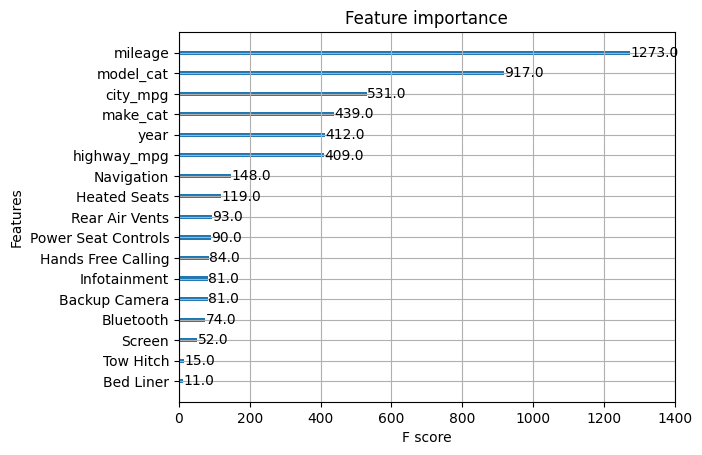

In [29]:
plot_importance(xgb)

In [30]:
df.columns

Index(['mileage', 'Bluetooth', 'Backup Camera', 'Infotainment', 'Screen',
       'Navigation', 'Hands Free Calling', 'Heated Seats',
       'Power Seat Controls', 'Rear Air Vents', 'Bed Liner', 'Tow Hitch',
       'city_mpg', 'highway_mpg', 'price', 'year', 'model_cat', 'make_cat'],
      dtype='object')